In [1]:
import yfinance as yf
import networkx as nx
from networkx.algorithms.approximation import clique
import numpy as np
import itertools 
from itertools import combinations
import time
import pickle
import json
import ast

In [2]:
stocks = ['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MFST', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']
data = yf.download(stocks,'2019-01-01','2020-01-01')
data = data['Adj Close']

n_days = 253

[*********************100%***********************]  30 of 30 completed


In [3]:
a_file = open("all_mult_sign_dict.json", "r")
output = a_file.read()
a_file.close()
all_mult_sign_dict = json.loads(output)

In [4]:
hipergraph_edges = {}
for num in all_mult_sign_dict.keys():
    hipergraph_edges[int(num)] = {}
    for ver in all_mult_sign_dict[num].keys():
        tuple_ver = tuple(sorted(ver.split()))
        hipergraph_edges[int(num)][tuple_ver] = all_mult_sign_dict[num][ver] / n_days

In [5]:
def get_cliques_from_hipergraph(hipergraph_edges, edge_size, threshold):    
    hipergraph_edges_threshold = {}
    for ver in hipergraph_edges:
        if hipergraph_edges[ver] >= threshold:
            hipergraph_edges_threshold[ver] = hipergraph_edges[ver]
    cliques = []
    stock_combinations = []
    for i in range(4, 9):
        stock_combinations.extend(list(combinations(stocks, i)))
    for big_comb in stock_combinations:
        if len(cliques) and len(big_comb) > len(cliques[-1]) + 1:
            break
        small_combinations = list(combinations(big_comb, edge_size))
        is_clique = True
        for small_comb in small_combinations:
            cur_three = tuple(sorted(small_comb))
            if cur_three not in hipergraph_edges_threshold:
                is_clique = False
                break
        if is_clique:
            cliques.append(big_comb)
    if len(cliques):
        max_clique_size = len(cliques[-1])
        max_cliques = []
        for cl in cliques:
            if max_clique_size == len(cl):
                max_cliques.append(cl)
        return max_cliques
    else:
        return None

In [6]:
def print_hipergraph_edges(hipergraph_edges, clique, n):
    edges = list(combinations(clique, n))
    for e in edges:
        print('Ребро клики {}: {}'.format(sorted(e), hipergraph_edges[n][tuple(sorted(e))]))
    print("\n")

In [7]:
def get_top(hipergraph_edges, n):
    sorted_dict = dict(sorted(hipergraph_edges[n].items(), key=lambda item: item[1], reverse=True)[:5])
    if len(sorted_dict):
        min_val = min(sorted_dict.values())
    
    for key, value in hipergraph_edges[n].items():
        if value == min_val and key not in sorted_dict:
            sorted_dict[key] = value
    print("Топ по совпадению знаков:")
    for elem in sorted_dict:
        print(elem, ": ", sorted_dict[elem])

In [8]:
def get_stat(size, thresold):
    print("Размер ребер {}, порог {}\n".format(size, thresold))
    max_cliques = get_cliques_from_hipergraph(hipergraph_edges[size], size, thresold)
    print(f"Количество найденных клик: {len(max_cliques)}" if len(max_cliques) else "Клики не найдены")
    if max_cliques is not None:
        max_size = len(max_cliques[0])
        print("Размер максимальной клики = ", max_size)
        for cl in max_cliques:
            ordered_cl = sorted(list(cl))
            print("Найденная клика в гиперграфе :{}".format(cl))
            print("Ее вероятность совпадения знаков :{}".format(hipergraph_edges[len(cl)][tuple(ordered_cl)]))
            print_hipergraph_edges(hipergraph_edges, cl, size)
        get_top(hipergraph_edges, max_size)

# Подбор порога, чтобы клики были размером на 1 акцию больше, чем ребро

In [9]:
get_stat(3, 0.58)

Размер ребер 3, порог 0.58

Количество найденных клик: 1
Размер максимальной клики =  4
Найденная клика в гиперграфе :('CAT', 'GS', 'JPM', 'MMM')
Ее вероятность совпадения знаков :0.5375494071146245
Ребро клики ['CAT', 'GS', 'JPM']: 0.6363636363636364
Ребро клики ['CAT', 'GS', 'MMM']: 0.6007905138339921
Ребро клики ['CAT', 'JPM', 'MMM']: 0.5889328063241107
Ребро клики ['GS', 'JPM', 'MMM']: 0.6363636363636364


Топ по совпадению знаков:
('CAT', 'GS', 'JPM', 'MMM') :  0.5375494071146245
('CAT', 'GS', 'HON', 'JPM') :  0.525691699604743
('CAT', 'GS', 'HON', 'MMM') :  0.5217391304347826
('AXP', 'CAT', 'GS', 'JPM') :  0.5138339920948617
('AXP', 'GS', 'JPM', 'MMM') :  0.5098814229249012
('CAT', 'GS', 'IBM', 'JPM') :  0.5098814229249012
('GS', 'HON', 'JPM', 'MMM') :  0.5098814229249012


In [10]:
get_stat(4, 0.5)

Размер ребер 4, порог 0.5

Количество найденных клик: 1
Размер максимальной клики =  5
Найденная клика в гиперграфе :('CAT', 'GS', 'HON', 'JPM', 'MMM')
Ее вероятность совпадения знаков :0.47035573122529645
Ребро клики ['CAT', 'GS', 'HON', 'JPM']: 0.525691699604743
Ребро клики ['CAT', 'GS', 'HON', 'MMM']: 0.5217391304347826
Ребро клики ['CAT', 'GS', 'JPM', 'MMM']: 0.5375494071146245
Ребро клики ['CAT', 'HON', 'JPM', 'MMM']: 0.5059288537549407
Ребро клики ['GS', 'HON', 'JPM', 'MMM']: 0.5098814229249012


Топ по совпадению знаков:
('CAT', 'GS', 'HON', 'JPM', 'MMM') :  0.47035573122529645
('CAT', 'GS', 'IBM', 'JPM', 'MMM') :  0.45849802371541504
('AXP', 'CAT', 'GS', 'HON', 'JPM') :  0.4505928853754941
('AXP', 'CAT', 'GS', 'JPM', 'MMM') :  0.4505928853754941
('CAT', 'GS', 'HON', 'IBM', 'JPM') :  0.44664031620553357
('CAT', 'GS', 'HON', 'IBM', 'MMM') :  0.44664031620553357


In [11]:
get_stat(5, 0.42)

Размер ребер 5, порог 0.42

Количество найденных клик: 2
Размер максимальной клики =  6
Найденная клика в гиперграфе :('AXP', 'CAT', 'GS', 'HON', 'JPM', 'MMM')
Ее вероятность совпадения знаков :0.40711462450592883
Ребро клики ['AXP', 'CAT', 'GS', 'HON', 'JPM']: 0.4505928853754941
Ребро клики ['AXP', 'CAT', 'GS', 'HON', 'MMM']: 0.4426877470355731
Ребро клики ['AXP', 'CAT', 'GS', 'JPM', 'MMM']: 0.4505928853754941
Ребро клики ['AXP', 'CAT', 'HON', 'JPM', 'MMM']: 0.4308300395256917
Ребро клики ['AXP', 'GS', 'HON', 'JPM', 'MMM']: 0.43873517786561267
Ребро клики ['CAT', 'GS', 'HON', 'JPM', 'MMM']: 0.47035573122529645


Найденная клика в гиперграфе :('CAT', 'GS', 'HON', 'IBM', 'JPM', 'MMM')
Ее вероятность совпадения знаков :0.4150197628458498
Ребро клики ['CAT', 'GS', 'HON', 'IBM', 'JPM']: 0.44664031620553357
Ребро клики ['CAT', 'GS', 'HON', 'IBM', 'MMM']: 0.44664031620553357
Ребро клики ['CAT', 'GS', 'HON', 'JPM', 'MMM']: 0.47035573122529645
Ребро клики ['CAT', 'GS', 'IBM', 'JPM', 'MMM']: 0.

In [12]:
get_stat(6, 0.37)

Размер ребер 6, порог 0.37

Количество найденных клик: 1
Размер максимальной клики =  7
Найденная клика в гиперграфе :('AXP', 'CAT', 'GS', 'HON', 'IBM', 'JPM', 'MMM')
Ее вероятность совпадения знаков :0.3675889328063241
Ребро клики ['AXP', 'CAT', 'GS', 'HON', 'IBM', 'JPM']: 0.391304347826087
Ребро клики ['AXP', 'CAT', 'GS', 'HON', 'IBM', 'MMM']: 0.3952569169960474
Ребро клики ['AXP', 'CAT', 'GS', 'HON', 'JPM', 'MMM']: 0.40711462450592883
Ребро клики ['AXP', 'CAT', 'GS', 'IBM', 'JPM', 'MMM']: 0.3952569169960474
Ребро клики ['AXP', 'CAT', 'HON', 'IBM', 'JPM', 'MMM']: 0.3794466403162055
Ребро клики ['AXP', 'GS', 'HON', 'IBM', 'JPM', 'MMM']: 0.3794466403162055
Ребро клики ['CAT', 'GS', 'HON', 'IBM', 'JPM', 'MMM']: 0.4150197628458498


Топ по совпадению знаков:
('AXP', 'CAT', 'GS', 'HON', 'IBM', 'JPM', 'MMM') :  0.3675889328063241
('CAT', 'CVX', 'GS', 'HON', 'IBM', 'JPM', 'MMM') :  0.35177865612648224
('AXP', 'CAT', 'CSCO', 'GS', 'HON', 'JPM', 'MMM') :  0.34782608695652173
('CAT', 'GS', 'HO

In [13]:
get_stat(7, 0.34)

Размер ребер 7, порог 0.34

Количество найденных клик: 8
Размер максимальной клики =  7
Найденная клика в гиперграфе :('AXP', 'CAT', 'CSCO', 'GS', 'HON', 'IBM', 'JPM')
Ее вероятность совпадения знаков :0.3438735177865613
Ребро клики ['AXP', 'CAT', 'CSCO', 'GS', 'HON', 'IBM', 'JPM']: 0.3438735177865613


Найденная клика в гиперграфе :('AXP', 'CAT', 'CSCO', 'GS', 'HON', 'JPM', 'MMM')
Ее вероятность совпадения знаков :0.34782608695652173
Ребро клики ['AXP', 'CAT', 'CSCO', 'GS', 'HON', 'JPM', 'MMM']: 0.34782608695652173


Найденная клика в гиперграфе :('AXP', 'CAT', 'CSCO', 'GS', 'IBM', 'JPM', 'MMM')
Ее вероятность совпадения знаков :0.3438735177865613
Ребро клики ['AXP', 'CAT', 'CSCO', 'GS', 'IBM', 'JPM', 'MMM']: 0.3438735177865613


Найденная клика в гиперграфе :('AXP', 'CAT', 'CVX', 'GS', 'HON', 'JPM', 'MMM')
Ее вероятность совпадения знаков :0.3438735177865613
Ребро клики ['AXP', 'CAT', 'CVX', 'GS', 'HON', 'JPM', 'MMM']: 0.3438735177865613


Найденная клика в гиперграфе :('AXP', 'CAT',

# Эксперименты с поиском клик больших, чем размером на одну акцию

## Размер ребра 3

In [14]:
get_stat(3, 0.55)

Размер ребер 3, порог 0.55

Количество найденных клик: 2
Размер максимальной клики =  5
Найденная клика в гиперграфе :('AXP', 'CAT', 'GS', 'HON', 'MMM')
Ее вероятность совпадения знаков :0.4426877470355731
Ребро клики ['AXP', 'CAT', 'GS']: 0.5652173913043478
Ребро клики ['AXP', 'CAT', 'HON']: 0.5849802371541502
Ребро клики ['AXP', 'CAT', 'MMM']: 0.5810276679841897
Ребро клики ['AXP', 'GS', 'HON']: 0.5573122529644269
Ребро клики ['AXP', 'GS', 'MMM']: 0.5573122529644269
Ребро клики ['AXP', 'HON', 'MMM']: 0.5652173913043478
Ребро клики ['CAT', 'GS', 'HON']: 0.5810276679841897
Ребро клики ['CAT', 'GS', 'MMM']: 0.6007905138339921
Ребро клики ['CAT', 'HON', 'MMM']: 0.6086956521739131
Ребро клики ['GS', 'HON', 'MMM']: 0.5731225296442688


Найденная клика в гиперграфе :('CAT', 'GS', 'HON', 'JPM', 'MMM')
Ее вероятность совпадения знаков :0.47035573122529645
Ребро клики ['CAT', 'GS', 'HON']: 0.5810276679841897
Ребро клики ['CAT', 'GS', 'JPM']: 0.6363636363636364
Ребро клики ['CAT', 'GS', 'MMM']:

In [15]:
get_stat(3, 0.53)

Размер ребер 3, порог 0.53

Количество найденных клик: 2
Размер максимальной клики =  6
Найденная клика в гиперграфе :('AXP', 'CAT', 'GS', 'HON', 'JPM', 'MMM')
Ее вероятность совпадения знаков :0.40711462450592883
Ребро клики ['AXP', 'CAT', 'GS']: 0.5652173913043478
Ребро клики ['AXP', 'CAT', 'HON']: 0.5849802371541502
Ребро клики ['AXP', 'CAT', 'JPM']: 0.5573122529644269
Ребро клики ['AXP', 'CAT', 'MMM']: 0.5810276679841897
Ребро клики ['AXP', 'GS', 'HON']: 0.5573122529644269
Ребро клики ['AXP', 'GS', 'JPM']: 0.6126482213438735
Ребро клики ['AXP', 'GS', 'MMM']: 0.5573122529644269
Ребро клики ['AXP', 'HON', 'JPM']: 0.549407114624506
Ребро клики ['AXP', 'HON', 'MMM']: 0.5652173913043478
Ребро клики ['AXP', 'JPM', 'MMM']: 0.5454545454545454
Ребро клики ['CAT', 'GS', 'HON']: 0.5810276679841897
Ребро клики ['CAT', 'GS', 'JPM']: 0.6363636363636364
Ребро клики ['CAT', 'GS', 'MMM']: 0.6007905138339921
Ребро клики ['CAT', 'HON', 'JPM']: 0.5731225296442688
Ребро клики ['CAT', 'HON', 'MMM']: 0.6

In [16]:
get_stat(3, 0.517)

Размер ребер 3, порог 0.517

Количество найденных клик: 3
Размер максимальной клики =  7
Найденная клика в гиперграфе :('AXP', 'CAT', 'GS', 'HON', 'IBM', 'INTC', 'MMM')
Ее вероятность совпадения знаков :0.3241106719367589
Ребро клики ['AXP', 'CAT', 'GS']: 0.5652173913043478
Ребро клики ['AXP', 'CAT', 'HON']: 0.5849802371541502
Ребро клики ['AXP', 'CAT', 'IBM']: 0.5573122529644269
Ребро клики ['AXP', 'CAT', 'INTC']: 0.549407114624506
Ребро клики ['AXP', 'CAT', 'MMM']: 0.5810276679841897
Ребро клики ['AXP', 'GS', 'HON']: 0.5573122529644269
Ребро клики ['AXP', 'GS', 'IBM']: 0.5296442687747036
Ребро клики ['AXP', 'GS', 'INTC']: 0.5217391304347826
Ребро клики ['AXP', 'GS', 'MMM']: 0.5573122529644269
Ребро клики ['AXP', 'HON', 'IBM']: 0.5454545454545454
Ребро клики ['AXP', 'HON', 'INTC']: 0.541501976284585
Ребро клики ['AXP', 'HON', 'MMM']: 0.5652173913043478
Ребро клики ['AXP', 'IBM', 'INTC']: 0.5296442687747036
Ребро клики ['AXP', 'IBM', 'MMM']: 0.541501976284585
Ребро клики ['AXP', 'INTC'

## Ребро размером 4

In [17]:
get_stat(4, 0.455)

Размер ребер 4, порог 0.455

Количество найденных клик: 3
Размер максимальной клики =  6
Найденная клика в гиперграфе :('AXP', 'CAT', 'GS', 'HON', 'IBM', 'MMM')
Ее вероятность совпадения знаков :0.3952569169960474
Ребро клики ['AXP', 'CAT', 'GS', 'HON']: 0.4901185770750988
Ребро клики ['AXP', 'CAT', 'GS', 'IBM']: 0.4624505928853755
Ребро клики ['AXP', 'CAT', 'GS', 'MMM']: 0.4901185770750988
Ребро клики ['AXP', 'CAT', 'HON', 'IBM']: 0.4782608695652174
Ребро клики ['AXP', 'CAT', 'HON', 'MMM']: 0.49407114624505927
Ребро клики ['AXP', 'CAT', 'IBM', 'MMM']: 0.48616600790513836
Ребро клики ['AXP', 'GS', 'HON', 'IBM']: 0.45849802371541504
Ребро клики ['AXP', 'GS', 'HON', 'MMM']: 0.48221343873517786
Ребро клики ['AXP', 'GS', 'IBM', 'MMM']: 0.466403162055336
Ребро клики ['AXP', 'HON', 'IBM', 'MMM']: 0.4624505928853755
Ребро клики ['CAT', 'GS', 'HON', 'IBM']: 0.4782608695652174
Ребро клики ['CAT', 'GS', 'HON', 'MMM']: 0.5217391304347826
Ребро клики ['CAT', 'GS', 'IBM', 'MMM']: 0.4980237154150198

In [18]:
get_stat(4, 0.435)

Размер ребер 4, порог 0.435

Количество найденных клик: 2
Размер максимальной клики =  7
Найденная клика в гиперграфе :('AXP', 'CAT', 'CSCO', 'GS', 'HON', 'IBM', 'MMM')
Ее вероятность совпадения знаков :0.3359683794466403
Ребро клики ['AXP', 'CAT', 'CSCO', 'GS']: 0.4624505928853755
Ребро клики ['AXP', 'CAT', 'CSCO', 'HON']: 0.47035573122529645
Ребро клики ['AXP', 'CAT', 'CSCO', 'IBM']: 0.45454545454545453
Ребро клики ['AXP', 'CAT', 'CSCO', 'MMM']: 0.45849802371541504
Ребро клики ['AXP', 'CAT', 'GS', 'HON']: 0.4901185770750988
Ребро клики ['AXP', 'CAT', 'GS', 'IBM']: 0.4624505928853755
Ребро клики ['AXP', 'CAT', 'GS', 'MMM']: 0.4901185770750988
Ребро клики ['AXP', 'CAT', 'HON', 'IBM']: 0.4782608695652174
Ребро клики ['AXP', 'CAT', 'HON', 'MMM']: 0.49407114624505927
Ребро клики ['AXP', 'CAT', 'IBM', 'MMM']: 0.48616600790513836
Ребро клики ['AXP', 'CSCO', 'GS', 'HON']: 0.45849802371541504
Ребро клики ['AXP', 'CSCO', 'GS', 'IBM']: 0.4426877470355731
Ребро клики ['AXP', 'CSCO', 'GS', 'MMM']

## Ребро размером 5

In [19]:
get_stat(5, 0.39)

Размер ребер 5, порог 0.39

Количество найденных клик: 1
Размер максимальной клики =  7
Найденная клика в гиперграфе :('AXP', 'CAT', 'GS', 'HON', 'IBM', 'JPM', 'MMM')
Ее вероятность совпадения знаков :0.3675889328063241
Ребро клики ['AXP', 'CAT', 'GS', 'HON', 'IBM']: 0.4189723320158103
Ребро клики ['AXP', 'CAT', 'GS', 'HON', 'JPM']: 0.4505928853754941
Ребро клики ['AXP', 'CAT', 'GS', 'HON', 'MMM']: 0.4426877470355731
Ребро клики ['AXP', 'CAT', 'GS', 'IBM', 'JPM']: 0.4268774703557312
Ребро клики ['AXP', 'CAT', 'GS', 'IBM', 'MMM']: 0.4268774703557312
Ребро клики ['AXP', 'CAT', 'GS', 'JPM', 'MMM']: 0.4505928853754941
Ребро клики ['AXP', 'CAT', 'HON', 'IBM', 'JPM']: 0.40711462450592883
Ребро клики ['AXP', 'CAT', 'HON', 'IBM', 'MMM']: 0.4268774703557312
Ребро клики ['AXP', 'CAT', 'HON', 'JPM', 'MMM']: 0.4308300395256917
Ребро клики ['AXP', 'CAT', 'IBM', 'JPM', 'MMM']: 0.41106719367588934
Ребро клики ['AXP', 'GS', 'HON', 'IBM', 'JPM']: 0.4150197628458498
Ребро клики ['AXP', 'GS', 'HON', 'IBM

In [20]:
get_stat(5, 0.37)

Размер ребер 5, порог 0.37

Количество найденных клик: 1
Размер максимальной клики =  8
Найденная клика в гиперграфе :('AXP', 'CAT', 'CSCO', 'GS', 'HON', 'IBM', 'JPM', 'MMM')
Ее вероятность совпадения знаков :0.3201581027667984
Ребро клики ['AXP', 'CAT', 'CSCO', 'GS', 'HON']: 0.41106719367588934
Ребро клики ['AXP', 'CAT', 'CSCO', 'GS', 'IBM']: 0.39920948616600793
Ребро клики ['AXP', 'CAT', 'CSCO', 'GS', 'JPM']: 0.4268774703557312
Ребро клики ['AXP', 'CAT', 'CSCO', 'GS', 'MMM']: 0.40711462450592883
Ребро клики ['AXP', 'CAT', 'CSCO', 'HON', 'IBM']: 0.3952569169960474
Ребро клики ['AXP', 'CAT', 'CSCO', 'HON', 'JPM']: 0.4031620553359684
Ребро клики ['AXP', 'CAT', 'CSCO', 'HON', 'MMM']: 0.4031620553359684
Ребро клики ['AXP', 'CAT', 'CSCO', 'IBM', 'JPM']: 0.38735177865612647
Ребро клики ['AXP', 'CAT', 'CSCO', 'IBM', 'MMM']: 0.39920948616600793
Ребро клики ['AXP', 'CAT', 'CSCO', 'JPM', 'MMM']: 0.391304347826087
Ребро клики ['AXP', 'CAT', 'GS', 'HON', 'IBM']: 0.4189723320158103
Ребро клики ['A

# Гистограммы

In [21]:
import seaborn as sns

sns_plot = sns.distplot(list(hipergraph_edges[2].values()))
sns_plot.set_title('Распределение весов гиперребер в 2-гиперграфе')
sns_plot.set_xlabel("вероятность совпадения знаков")
sns_plot.set_ylabel("количество вершин")
fig = sns_plot.get_figure()

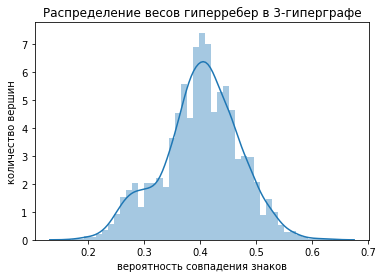

In [22]:
sns_plot = sns.distplot(list(hipergraph_edges[3].values()))
sns_plot.set_title('Распределение весов гиперребер в 3-гиперграфе')
sns_plot.set_xlabel("вероятность совпадения знаков")
sns_plot.set_ylabel("количество вершин")
fig = sns_plot.get_figure()

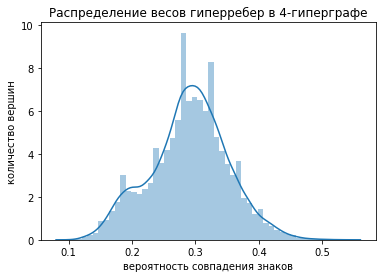

In [23]:
sns_plot = sns.distplot(list(hipergraph_edges[4].values()))
sns_plot.set_title('Распределение весов гиперребер в 4-гиперграфе')
sns_plot.set_xlabel("вероятность совпадения знаков")
sns_plot.set_ylabel("количество вершин")
fig = sns_plot.get_figure()

Text(0, 0.5, 'количество вершин')

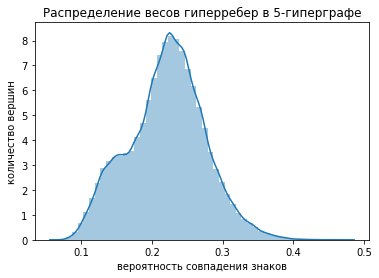

In [24]:
sns_plot = sns.distplot(list(hipergraph_edges[5].values()))
sns_plot.set_title('Распределение весов гиперребер в 5-гиперграфе')
sns_plot.set_xlabel("вероятность совпадения знаков")
sns_plot.set_ylabel("количество вершин")
#fig = sns_plot.get_figure()

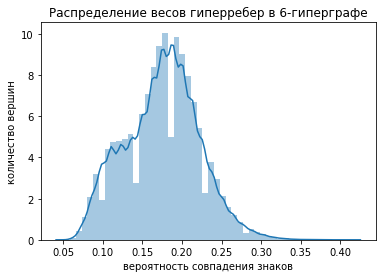

In [25]:
sns_plot = sns.distplot(list(hipergraph_edges[6].values()))
sns_plot.set_title('Распределение весов гиперребер в 6-гиперграфе')
sns_plot.set_xlabel("вероятность совпадения знаков")
sns_plot.set_ylabel("количество вершин")
fig = sns_plot.get_figure()

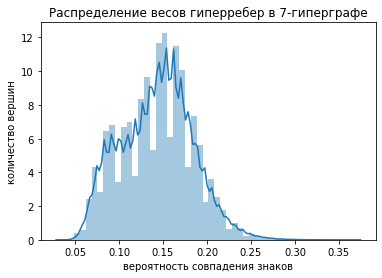

In [26]:
sns_plot = sns.distplot(list(hipergraph_edges[7].values()))
sns_plot.set_title('Распределение весов гиперребер в 7-гиперграфе')
sns_plot.set_xlabel("вероятность совпадения знаков")
sns_plot.set_ylabel("количество вершин")
fig = sns_plot.get_figure()

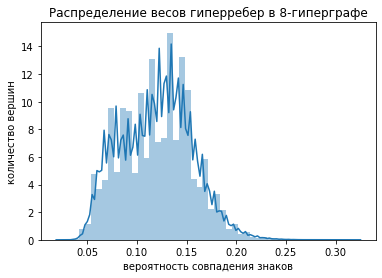

In [27]:
sns_plot = sns.distplot(list(hipergraph_edges[8].values()))
sns_plot.set_title('Распределение весов гиперребер в 8-гиперграфе')
sns_plot.set_xlabel("вероятность совпадения знаков")
sns_plot.set_ylabel("количество вершин")
fig = sns_plot.get_figure()